In [13]:
import pandas as pd

ods = (
    pd.read_excel(
        "DB AF Completo 1.ods",
    )
    .loc[:, ["ID", "Phenotype", "Low Voltage / Scar area"]]
    .rename(columns={"ID": "Patient ID", "Low Voltage / Scar area": "Substrate"})
    .dropna(axis=0, how="any")
    .astype({"Patient ID": int})
)
csv = (
    pd.read_csv("lase.csv", sep=",")
    .dropna(axis=0, how="any")
    .astype({"Patient ID": int})
)
display(ods)
csv

,Patient ID,Phenotype,Substrate
3,9,Persistent,Abnormal
4,10,Paroxysmal,Normal
5,11,Persistent,Normal
6,12,Persistent,Abnormal
7,13,Persistent,Abnormal
...,...,...,...
177,160,Parossistica,Normale
178,161,Parossistica,Normale
179,162,Parossistica,Normale
232,215,Parossistica,Normale


,Patient ID,Entropy,LASE
2,100,0,2.354451
3,101,0,1.504809
4,102,0,1.355475
5,103,0,1.965870
6,104,0,2.106482
...,...,...,...
94,94,0,2.089640
95,95,0,1.483407
96,96,0,2.106952
97,97,0,1.955019


In [18]:
# Join the two dataframes on the "ID" column
merged_df = pd.merge(
    ods.loc[:, ["Patient ID", "Phenotype", "Substrate"]],
    csv,
    on="Patient ID",
    how="inner",
)

phenotype_mapping = {
    "Long standing persistent": "Persistente",
    "Persistente": "Persistente",
    "Parossistica": "Parossistica",
    "Parossistico": "Parossistica",
}

substrate_mapping = {
    "Normale": "Normale",
    "Abnormal": "Anormale",
    "Patologia": "Anormale",
    "Patologia ": "Anormale",
    "Patologia altri distretti": "Anormale",
    "Patologia parete posteriore": "Anormale",
    "Patologia parete posteriore e anteriore": "Anormale",
    "Patologia posteriore + altri": "Anormale",
    "Patologia posteriore e+ altri": "Anormale",
}

merged_df["Phenotype"] = merged_df["Phenotype"].map(phenotype_mapping)
merged_df["Substrate"] = merged_df["Substrate"].map(substrate_mapping)

merged_df

,Patient ID,Phenotype,Substrate,Entropy,LASE
0,40,Parossistica,Anormale,0,1.946070
1,41,Parossistica,Normale,0,2.157646
2,42,Parossistica,Normale,0,1.422259
3,43,Persistente,Anormale,0,1.350502
4,45,Persistente,Anormale,0,1.668588
...,...,...,...,...,...
86,147,Parossistica,Normale,0,1.942938
87,148,Parossistica,Normale,0,1.842904
88,149,Parossistica,Normale,0,1.300020
89,150,Parossistica,Normale,0,2.294072


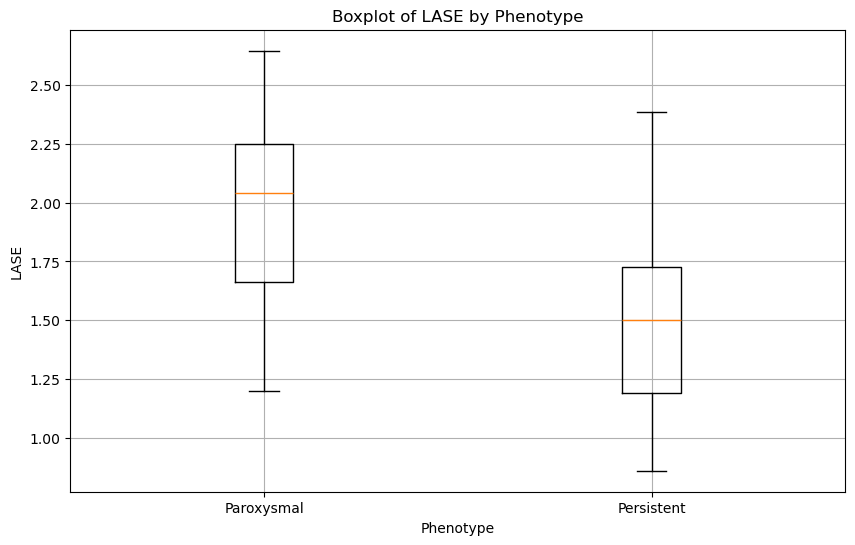

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.boxplot(
    [
        merged_df[merged_df["Phenotype"] == "Parossistica"]["LASE"],
        merged_df[merged_df["Phenotype"] == "Persistente"]["LASE"],
    ],
    tick_labels=["Paroxysmal", "Persistent"],
)
plt.title("Boxplot of LASE by Phenotype")
plt.ylabel("LASE")
plt.xlabel("Phenotype")
plt.grid()
plt.show()

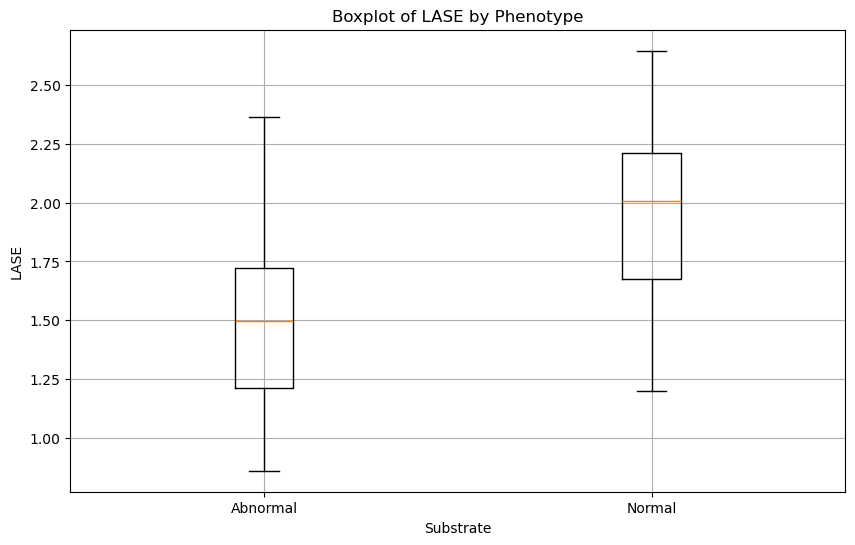

In [20]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.boxplot(
    [
        merged_df[merged_df["Substrate"] == "Anormale"]["LASE"],
        merged_df[merged_df["Substrate"] == "Normale"]["LASE"],
    ],
    tick_labels=["Abnormal", "Normal"],
)
plt.title("Boxplot of LASE by Phenotype")
plt.ylabel("LASE")
plt.xlabel("Substrate")
plt.grid()
plt.show()